In [1]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Clase PyMC 2 - Cuidar y mimar a mis cadenas de Markov


## Declaracion del modelo

 Se define el modelo dentro de un contexto with, creando la variable aleatoria θ y la variable observada y_obs que ondiciona sobre los datos observados Y.

In [2]:
Y = np.array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1])

# Declarar el modelo
with pm.Model() as model:
    # Especificar el prior para θ
    θ = pm.Beta("θ", alpha=1, beta=1)
    # Especificar la likelihood, y condicionarla sobre los datos observados Y
    y_obs = pm.Binomial("y_obs", n=1, p=θ, observed=Y)
# Representar el modelo
model

    θ ~ Beta(1, 1)
y_obs ~ Binomial(1, θ)

In [3]:
#Muestreo de la Distribución Posterior
with model:
    idata = pm.sample(draws=10_000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 32 seconds.


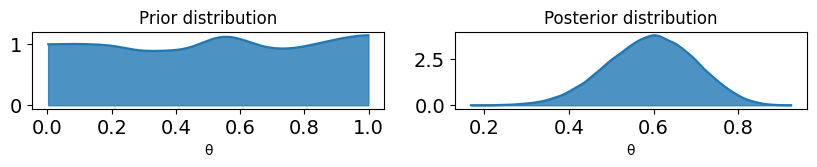

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 1))
# Prior
az.plot_dist(pm.draw(θ, 1000), fill_kwargs={'alpha':.8}, ax=axs[0])
axs[0].set_title("Prior distribution")
axs[0].set_xlabel("θ")
# Posterior
az.plot_dist(idata.posterior["θ"], fill_kwargs={'alpha':.8}, ax=axs[1])
axs[1].set_title("Posterior distribution")
axs[1].set_xlabel("θ")
plt.show()

In [5]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.592,0.103,0.394,0.78,0.001,0.001,17593.0,27892.0,1.0


## **¿Por qué usar múltiples cadenas?**

El uso de múltiples cadenas permite evaluar la convergencia del muestreo. Si todas las cadenas se comportan de manera similar y se distribuyen alrededor de la misma región de la distribución posterior, esto sugiere que el muestreo está funcionando correctamente y ha alcanzado la convergencia.


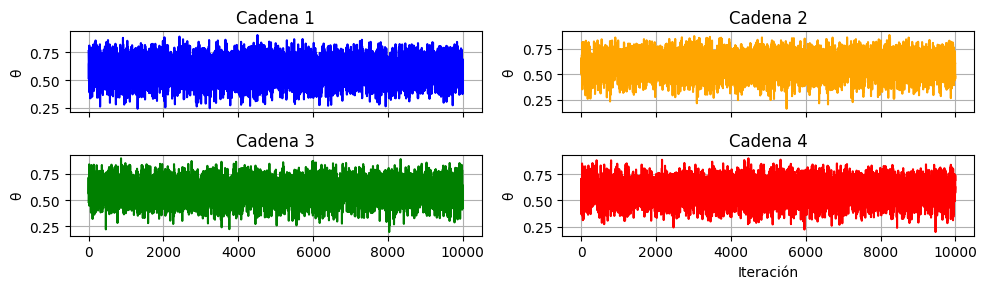

In [ ]:
# Gráficos de trazas para evaluar la convergencia en un formato 2x2
fig, axes = plt.subplots(2, 2, figsize=(10,3), sharex=True)
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

# Obtener las trazas de cada cadena
traces = idata.posterior["θ"].values

# Colores personalizados para cada cadena
colors = ["blue", "orange", "green", "red"]

# Graficar cada cadena en sus respectivos subgráficos
for i in range(len(traces)):
    axes[i].plot(traces[i], color=colors[i])
    axes[i].set_title(f"Cadena {i + 1}")
    axes[i].set_ylabel("θ")
    axes[i].grid()

plt.xlabel("Iteración")
plt.tight_layout()
plt.show()

## **Visualización de las Cadenas de Markov**

Uno de los pasos más importantes en el análisis de las cadenas de Markov es asegurarse de que las muestras obtenidas sean confiables para inferir los parámetros del modelo. Para esto tenemos las técnicas de visualización de las cadenas.

1. **Traceplot**

2. **Trace Rank Plot**

### **Traceplot**

El traceplot muestra la evolución de las muestras a lo largo de las iteraciones de la cadena de Markov. Cada muestra (eslabón de la cadena) se representa por un punto en el gráfico, y estos puntos están conectados por una línea que indica cómo ha cambiado la cadena en el espacio de parámetros.


¿Que queremos ver en el Traceplot?
* **Estacionariedad**
* **Buen Mezclado**
* **Convergencia**


In [6]:
# Definimos un modelo simple de una sola variable
exitos = 19
ensayos = 30

with pm.Model() as binomodel:
    theta = pm.Uniform('theta', lower=0, upper=1)  # Prior
    y = pm.Binomial("y", n=ensayos, p=theta, observed=exitos)  # Likelihood

    # Muestreo
    trace = pm.sample(1000, return_inferencedata=True, chains=4, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [theta]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [7]:
binomodel

theta ~ Uniform(0, 1)
    y ~ Binomial(30, theta)

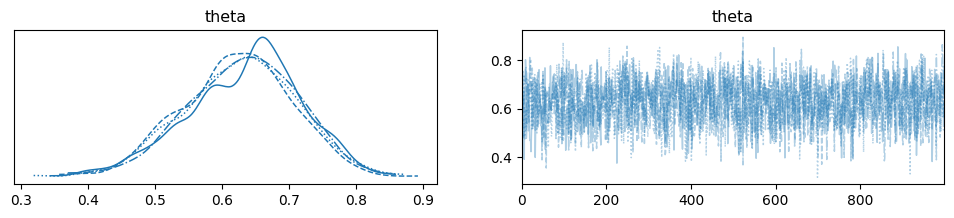

In [8]:
# Visualizamos las cadenas de Markov
az.plot_trace(trace)
plt.show()

### **Trace Rank Plot**

Este gráfico ofrece una representación clara de cómo se distribuyen las muestras de los parámetros en las diferentes cadenas, facilitando la identificación de problemas de convergencia.

Similar a los trace plots, pero en este caso, se clasifican las muestras por valor. Cada muestra de cada cadena se coloca en un gráfico de rangos.


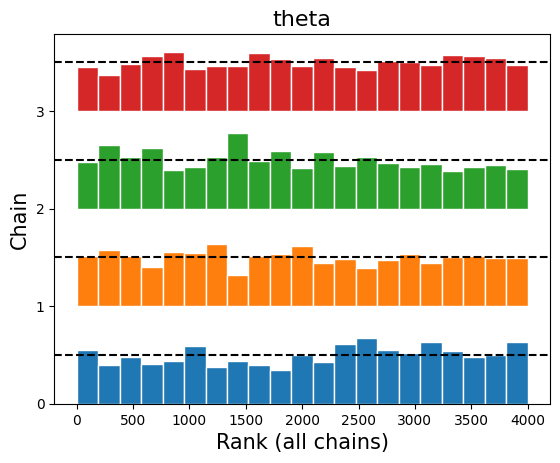

In [9]:
# Visualizamos el trace rank plot
az.plot_rank(trace)
plt.show()

## Estimadores de Convergencia
Cuando ejecutas una simulación MCMC, necesitamos asegurarnos de que las cadenas han alcanzado su equilibrio (o convergencia) y que las muestras obtenidas son representativas de la distribución posterior.

Los estimadores más importantes para evaluar la convergencia y la calidad de las muestras:

- **R-hat**
- **Effective Sample Size (ESS)**

In [10]:
# Definir modelo de ejemplo
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=[1, 2, 3, 4, 5])

    # Realizar muestreo MCMCa
    trace = pm.sample(2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


### **R-hat (estimador de Gelman-Rubin)**

Es una métrica que se utiliza para medir si las cadenas de Markov han convergido a la misma distribución posterior. El R-hat compara la varianza entre varias cadenas con la varianza dentro de cada cadena individual. Si todas las cadenas convergen correctamente, entonces las varianzas dentro y entre las cadenas deberían ser similares.

 Compara la varianza entre todas las cadenas con la varianza dentro de cada cadena

In [11]:
# Evaluar el R-hat
r_hat_values = az.rhat(trace)
print(r_hat_values)

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    mu       float64 8B 1.0
    sigma    float64 8B 1.001


- **R-hat ≈ 1:** Significa que las cadenas han convergido a la misma distribución posterior. Esto es lo que buscamos, ya que indica que las cadenas están explorando la misma región del espacio de parámetros.

- **R-hat > 1**: Indica que las cadenas no han convergido completamente y están explorando diferentes regiones del espacio de parámetros. Esto significa que las muestras podrían no ser representativas de la distribución posterior.


- **R-hat mucho mayor a 1**: Indica una falta severa de convergencia, lo que implica que el muestreo no es confiable y se necesita ejecutar el algoritmo MCMC durante más tiempo o ajustar el modelo.

### **Effective Sample Size (ESS)**

Mide cuántas muestras independientes se han obtenido de la distribución posterior. A veces, en los métodos MCMC, las muestras pueden estar correlacionadas debido a la naturaleza de las cadenas de Markov, lo que significa que no todas las muestras son completamente "nuevas" o "independientes". El ESS ajusta por esta correlación y nos da una estimación de cuántas muestras útiles tenemos realmente. 

cuantas nos sirven poara hacer muestras confiables, que sirven para hacer inferencia

- **Effective Sample Size (ESS)**: Dice cuántas muestras efectivas tenemos después de descontar la correlación entre muestras. Un ESS bajo indica que las muestras no son independientes.

- **Bulk-ESS**: Evalúa la calidad de las muestras en el centro de la distribución.
- **Tail-ESS**: Evalúa la calidad de las muestras en las colas de la distribución.

In [ ]:
# Calcular ESS
ess_values = az.ess(trace)
print(ess_values)

# Calcular Bulk-ESS y Tail-ESS
bulk_ess = az.ess(trace, method="bulk")
tail_ess = az.ess(trace, method="tail")

print("Bulk-ESS:", bulk_ess)
print("Tail-ESS:", tail_ess)

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    mu       float64 8B 3.782e+03
    sigma    float64 8B 3.561e+03
Bulk-ESS: <xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    mu       float64 8B 3.782e+03
    sigma    float64 8B 3.561e+03
Tail-ESS: <xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    mu       float64 8B 3.28e+03
    sigma    float64 8B 4.232e+03







 - ESS:

  - ESS alto: Significa que la mayoría de las muestras son independientes, lo cual es bueno. Cuanto más alto sea el ESS, más confiable será tu inferencia.
  -  ESS bajo: Indica que las muestras están fuertemente correlacionadas y, por lo tanto, menos confiables. A veces esto ocurre porque la cadena no está explorando el espacio de parámetros de manera eficiente o porque se necesita más muestreo.


- Bulk-ESS y Tail-ESS:

 - Bulk-ESS: Evalúa el tamaño efectivo de las muestras en el centro de la distribución posterior. Si el Bulk-ESS es bajo, significa que la cadena no está explorando bien el bulk o parte central de la distribución.
  - Tail-ESS: Evalúa el tamaño efectivo de las muestras en las colas de la distribución posterior. Un Tail-ESS bajo sugiere que no has obtenido suficientes muestras en las colas de la distribución, lo que es importante si te interesa hacer inferencias sobre eventos poco probables pero posibles.
  

## Casos de Fallos en las Cadenas de MCMC


Las cadenas de Markov pueden fallar en converger o explorar el espacio de parámetros de manera adecuada por diversas razones:

- Priors Extremadamente Planos y Poca Data

- Parámetros No Identificables



###  **Priors Planos o No informativos**


Cuando usamos priors no informativos (extremadamente planos) junto con una pequeña cantidad de datos, las cadenas pueden comportarse de manera errática, explorando valores extremos que no tienen sentido, lo que dificulta la convergencia y produce resultados poco confiables.

Esto se debe a que los priors planos no limitan la exploración del espacio de parámetros, permitiendo que la cadena se mueva en regiones de baja probabilidad sin restricciones.

- Las cadenas exploran áreas del espacio de parámetros que son improbables y pueden "escapar" hacia valores extremos.
- Esto provoca que las cadenas no converjan adecuadamente y que las estimaciones sean poco precisas.

Ejemplo

Tenemos dos observaciones de una distribución normal: -1 y 1.


In [12]:
# Datos: las observaciones -1 y 1
y = np.array([-1, 1])

# Modelo con prioris planas
with pm.Model() as model_flat_priors:
    # Distribuciones priors
    alpha = pm.Normal('alpha', mu=0, sigma=1000)
    sigma = pm.Exponential('sigma', lam= 0.0001)

    # Likelihood: distribuciones normales
    mu = alpha
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Muestreo con tres cadenas
    trace_flat_priors = pm.sample(1500, chains=3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [alpha, sigma]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 1_500 draw iterations (3_000 + 4_500 draws total) took 9 seconds.
There were 2062 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Diagnóstico del Modelo con Priors Planos**

In [13]:
az.summary(trace_flat_priors)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-20.301,308.745,-677.627,611.980,12.058,12.75,539.0,417.0,1.76
sigma,446.433,1360.184,11.147,1734.174,138.623,98.32,5.0,3.0,1.78


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


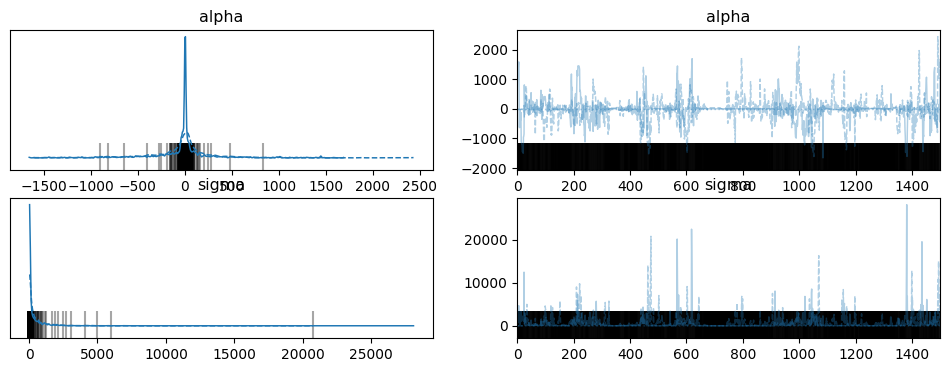

In [14]:
# Visualización del trace y el posterior
az.plot_trace(trace_flat_priors)
plt.show()

El traceplot muestra que las cadenas de Markov saltan erráticamente entre valores extremos, lo que sugiere que no están bien mezcladas ni convergiendo hacia distribuciones estacionarias.

### **Solución: Priors Débilmente Informativos**

Para solucionar este problema, ajustamos las priors para que sean débilmente informativas:

* Para alpha, usamos un prior normal centrado en 1 con una desviación estándar más razonable.
* Para sigma, utilizamos un prior exponencial con un parámetro mayor.

In [15]:
# Modelo con priors débilmente informativos
with pm.Model() as model_weak_priors:
    # Priors débilmente informativos
    alpha = pm.Normal('alpha', mu=1, sigma=10) # Prior débilmente informativo para alpha
    sigma = pm.Exponential('sigma', 1)  # Prior más informativo para sigma

    # Distribución normal con los parámetros
    mu = alpha
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Muestreo
    #trace_informative = pm.sample(2000, tune=1000, return_inferencedata=False)
    # Muestreo con cadenas de Markov
    trace_weak_priors = pm.sample(1500, chains=3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [alpha, sigma]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 1_500 draw iterations (3_000 + 4_500 draws total) took 8 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [16]:
# Resumen de los resultados
az.summary(trace_weak_priors)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.046,1.311,-2.488,2.371,0.053,0.052,1058.0,610.0,1.00
sigma,1.573,0.857,0.501,3.165,0.027,0.022,1239.0,1182.0,1.01


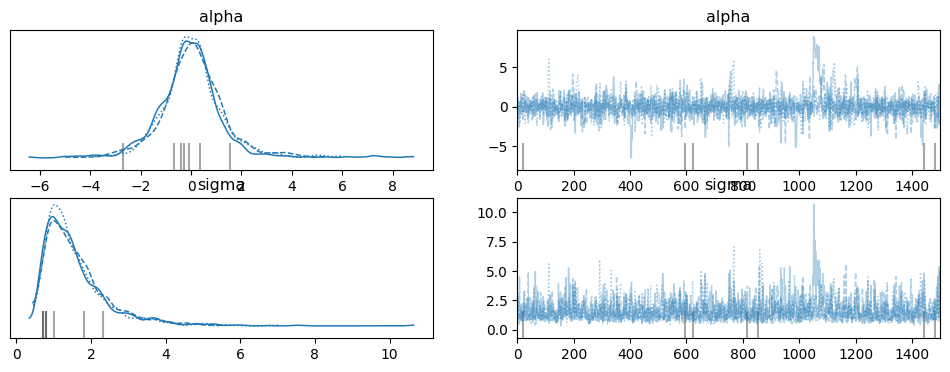

In [17]:
# Trazas del modelo con priors débiles
az.plot_trace(trace_weak_priors)
plt.show()

CONCLUSION: AL PASAR PRIOR LEVEMENTE INFORMATIVO, ESTABILIZAS LA CADENA

Este traceplot mostrará cadenas más estables y estacionarias, en comparación con las cadenas erráticas del modelo con priors planos.

**¿Por qué falló el primer modelo?**

El primer modelo falló porque las priors eran demasiado planas, permitiendo que las cadenas de Markov exploraran valores extremos que no tenían sentido, especialmente con solo dos observaciones. Al introducir priors más informativas, aunque sean débiles, estabilizamos el proceso de muestreo, evitando que las cadenas exploren regiones irrelevantes del espacio de parámetros.

###  **Parámetros No Identificables**




En este ejemplo, exploramos cómo los parámetros no identificables pueden afectar negativamente a las cadenas de Markov. En particular, cuando dos parámetros están correlacionados y solo se puede identificar su suma, las cadenas muestran un mal comportamiento y los resultados pueden ser engañosos. Para abordar estos problemas, se puede usar información adicional a través de priors débiles.

**Simulación de Datos**

Primero simulamos 100 observaciones de una distribución normal con media cero y desviación estándar de 1. Esto nos proporciona los datos conocidos que utilizaremos para ajustar el modelo

In [18]:
# Simulación de datos
np.random.seed(41)
y = np.random.normal(0, 1, 100)

**Modelo No Identificable**


In [19]:
# Definición del modelo no identificable
with pm.Model() as model_3:
    # Priors
    a1 = pm.Normal('a1', mu=0, sigma=1000)
    a2 = pm.Normal('a2', mu=0, sigma=1000)
    sigma = pm.Exponential('sigma', lam=1)

    # Definición de mu
    mu = a1 + a2

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # MCMC
    trace_3 = pm.sample(2000, chains=3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [a1, a2, sigma]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package
s\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 25175 seconds.
There were 734 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Diagnóstico de Convergencia**

El diagnóstico de la cadena muestra problemas graves. Los valores de a1 y a2 están en extremos opuestos, con desviaciones estándar enormes. Esto sugiere que no podemos identificar a1 y a2 individualmente, solo su suma.

In [20]:
az.summary(trace_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,-8.368,441.775,-863.305,777.403,198.163,149.282,5.0,22.0,2.07
a2,8.230,441.772,-777.658,863.272,198.162,149.282,5.0,22.0,2.07
sigma,1.110,0.073,0.965,1.216,0.028,0.021,8.0,44.0,1.35


Los resultados muestran valores sospechosos con altos errores estándar y bajas eficiencias (n_eff bajo y Rhat alto). Esto confirma que el modelo tiene problemas de identificación.

### **Mejora del Modelo con Priors Débilmente Informativos**

Para mejorar la estimación de los parámetros, ajustamos los priors a valores más razonables. Priors débiles, en este caso, pueden estabilizar el muestreo.

In [ ]:
with pm.Model() as model_3:
    # Priors más débiles
    a1 = pm.Normal('a1', mu=0, sigma=10)
    a2 = pm.Normal('a2', mu=0, sigma=10)
    sigma = pm.Exponential('sigma', lam=1)

    # Definición de mu
    mu = a1 + a2

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # MCMC
    trace_3 = pm.sample(2000, chains=3, return_inferencedata=True)

Sampling chain 2, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:01:39

**Verificación de Resultados**

Ahora, los parámetros son mejor identificados. La suma de a1 y a2 sigue siendo identificable, pero los valores individuales están mucho más cerca de lo esperado, con intervalos de credibilidad más razonables.

In [ ]:
az.summary(trace_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,-0.156,6.886,-13.543,12.312,0.164,0.120,1756.0,2092.0,1.0
a2,0.017,6.887,-12.408,13.418,0.164,0.120,1755.0,2081.0,1.0
sigma,1.072,0.080,0.930,1.226,0.002,0.001,2126.0,2059.0,1.0


Los valores de Rhat ahora están cerca de 1, y n_eff es mucho mayor, lo que indica que las cadenas están convergiendo y mezclándose adecuadamente.


**Visualización de las Cadenas**

Podemos visualizar los trazados de las cadenas para ver cómo se comportan con los priors débiles en comparación con los priors planos.

array([[<Axes: title={'center': 'a1'}>, <Axes: title={'center': 'a1'}>],
       [<Axes: title={'center': 'a2'}>, <Axes: title={'center': 'a2'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

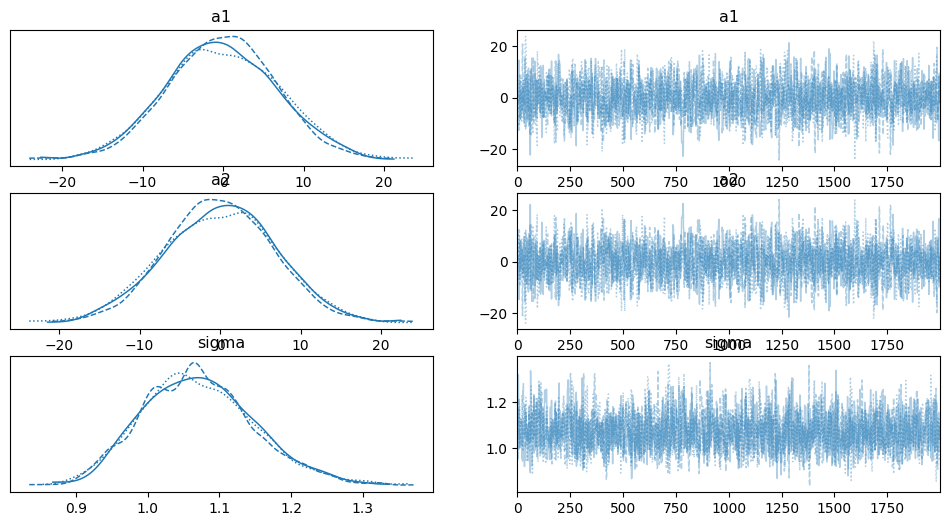

In [ ]:
az.plot_trace(trace_3)

Conclusión
Este ejemplo muestra cómo los parámetros no identificables pueden causar que las cadenas de Markov muestren mal comportamiento. En estos casos, el uso de priors más informativos (aunque débiles) estabiliza el muestreo, mejora la eficiencia y evita que las cadenas exploren valores extremos no razonables.